# PMM Implementation: Transverse-Field Ising Model

## Goal: Train a PMM to find the ground-state eigenvalues of the 1D Hamiltonian <br>

$$
H = -J\left(\sum_{\langle i,j\rangle} \sigma_{z,i}\sigma_{z,j} + g\sum_j \sigma_{x,j}\right)
$$

### (1) Construct the Hamiltonian.

We have N total lattice sites, so $|\psi\rangle = |\chi_1\rangle |\otimes\rangle |\chi_2\rangle \otimes \cdots \otimes |\chi_N\rangle$. Wrap $|\psi\rangle$ in a $2^N$-dimensional coordinate vector. The basis states are labelled by bit strings $|b_1 b_2 \dots b_N\rangle$ (for example, the ordered basis for three spin sites looks like \{$|\uparrow\uparrow\uparrow\rangle, |\uparrow\uparrow\downarrow\rangle, |\uparrow\downarrow\uparrow\rangle, |\uparrow\downarrow\downarrow\rangle, |\downarrow\uparrow\uparrow\rangle,...|\downarrow\downarrow\downarrow\rangle\}$ -- the $\uparrow$s correspond to 0 and the $\downarrow$s correspond to 1s). Then, the effective z-Pauli matrices $\sigma_{z,i}$ are $2^N\times 2^N$ diagonal matrices where every element on the diagonal is either 1 or -1 depending on if the $i$th spin site is up or down in that basis state. The effective x-Pauli matrices, $\sigma_{x,i}$ are $2^N\times 2^N$ matrices with 1s for every matrix element where the $i$th spin is flipped (for example, $\langle\uparrow\uparrow\cdots\uparrow\cdots\uparrow\uparrow|\sigma_{x,i}|\uparrow\uparrow\cdots\downarrow\cdots\uparrow\uparrow\rangle)$=1.

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from jax import config
config.update("jax_enable_x64", True)

In [2]:
# construct the 3 Pauli matrices at every point i given the number of lattice points N
def construct_Pauli_matrices(N):
  sigmas = []
  for i in range(N):
    sigmas_at_site_i = []

    # construct z-component of Pauli matrices
    zs = (-1)**( (np.arange(2**N) >> i) & 1 )
    sigmas_at_site_i.append(ss.diags(zs, format='csr', dtype=np.complex128))

    # construct x-component of Pauli matrices
    data = np.ones(2**N, dtype=np.complex128)
    rows = np.arange(2**N)
    cols = rows ^ (1 << i)
    sigmas_at_site_i.append( ss.coo_matrix((data, (rows, cols)), shape=(2**N, 2**N)).tocsr() )

    # construct y-component of Pauli matrices
    rows = np.arange(2**N)
    data = (-1)**( (rows >> i) & 1 ) * 1j
    cols = rows ^ (1 << i)
    sigmas_at_site_i.append( ss.coo_matrix((data, (rows, cols)), shape=(2**N, 2**N)).tocsr() )

    # add [sigma_z,i, sigma_x,i, sigma_y,i] to sigmas
    sigmas.append(sigmas_at_site_i)
  return sigmas

# construct the Ising Hamiltonian in 1D
def create_Ising_Hamiltonian(N, J, g):
  sigmas = construct_Pauli_matrices(N)
  H1 = ss.csr_matrix((2**N, 2**N), dtype=np.complex128)
  H2 = ss.csr_matrix((2**N, 2**N), dtype=np.complex128)
  for i, sigma in enumerate(sigmas):
    H1 += sigma[0] @ sigmas[(i + 1) % N][0]
    H2 += sigma[1]
  return -J * (H1 + g * H2)

### (2) Compute the eigenvalues for a sample set of $g$-values, $E_0(g)$.

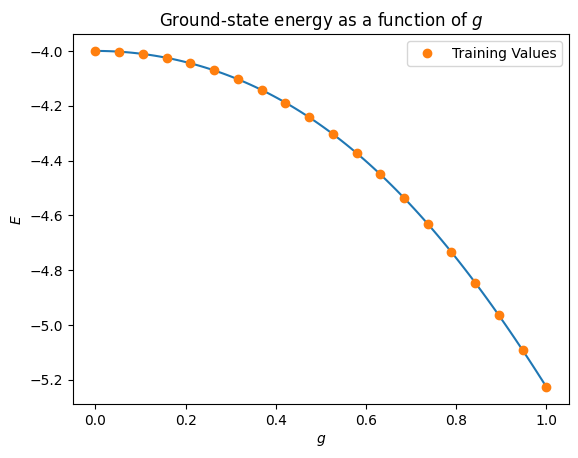

In [3]:
# constants
N = 4                             # number of spin sites
J = 1                             # coupling strength
k_num = 1

# transverse-field strength
g_test = np.linspace(0, 1, 100)   # test g-values for comparison
g_train = np.linspace(0, 1, 20)   # training g-values for PMM training

# compute eigenvalues for each g-value (test and train)
eigenvalues_test = np.zeros((len(g_test), k_num), dtype=np.float64)
for i, g in enumerate(g_test):
  H = create_Ising_Hamiltonian(N, J, g)
  eigvals, _ = ss.linalg.eigsh(H, k=k_num, which='SA')
  eigenvalues_test[i] = np.sort(eigvals)

eigenvalues_train = np.zeros((len(g_train), k_num), dtype=np.float64)
for i, g in enumerate(g_train):
  H = create_Ising_Hamiltonian(N, J, g)
  eigvals, _ = ss.linalg.eigsh(H, k=k_num, which='SA')
  eigenvalues_train[i] = np.sort(eigvals)

# plot eigenvalues for each g-value
fig, ax = plt.subplots()
ax.plot(g_test, eigenvalues_test, '-')
ax.plot(g_train, eigenvalues_train, 'o', label='Training Values')
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$E$')
ax.set_title(r'Ground-state energy as a function of $g$')
ax.legend()
plt.show()

### (3) Define the PMM
We construct our parameters using an affine:
$$
  M(g) = A + gB,
$$
where $g$ is the transverse-field strength. We define the loss function as
$$
  L = \frac{1}{N}\sum_{g_i}\sum_{k=1}^{k_\text{max}} (f(g_i, M)_k - E_{i,k})^2
$$
with $\{g_i\}_i$ training points, $f(g_i, M)_k$ being the $k$-smallest eigenvalue of the Hamiltonian $M$ at sample point $g_i$, and $E_{i,k}$ being the true $k$-smallest eigenvalue for $H$ at $g_i$. $N$ is the total number of training points multiplied by $k_\text{max}$ (total sampled values). It should be noted that this example uses BBGD as opposed to the MBGD standard.

Aside: for complex paramters, the direction that points toward steepest descent is $-\partial L /\partial z^* =- \frac{1}{2}(\partial L/\partial x + i \partial L/\partial y)$ for a complex parameter $z=x+iy$. Intuitively, the derivative with respect to a complex variable is looking at the change in $L$ as you vary both the real and imaginary part of that complex variable. $\partial L / \partial z = \frac{1}{2} (\partial L /\partial x - i \partial L /\partial y)$ doesn't actually point toward steepest ascent in the Euclidean sense (steepest ascent defined via the Euclidean inner product). But, $\partial L / \partial z^*$ does. Further, for $L:\mathbb{C}^d\rightarrow \mathbb{R}$, $\partial L / \partial z^* = (\partial L / \partial z)^* = (\nabla_z L)^*$.

$\partial L / \partial z$ and $\partial L / \partial z^*$ are Wirtinger derivatives; they're definitions that are motivated by expanding the differential of a complex-valued function in terms of x, y, then grouping $z$ and $z^*$ terms. You could instead define the gradient $\nabla_z L = [\partial L/ \partial x, \partial L / \partial y]$ and stick with $-\nabla_z L$ for steepest descent since $L$ is real-valued, but it's much easier computationally to use the Wirtinger formalism (if we don't, then we increase our dimesion by a factor of two. In the Wirtinger formalism, we don't change the dimension or variable type at all).

In [4]:
# construct Hamiltonian M after adjusting A, B
def M(A, B, g):
  # force hermiticity
  A = .5 * (A + A.conj().T)
  B = .5 * (B + B.conj().T)

  # if g is given as a scalar, just return A + gB
  # if g is given as a jnp array, return [M(g1), ..., M(gN)]
  if jnp.isscalar(g):
    return A + g * B
  else:
    # reshape g array so that it has dimension (:, 1, 1) for broadcasting with A, B
    return A + g[:, None, None] * B

# get the k-lowest eigenvalues of M (or Ms if M is given as a batch of matrices)
def get_eigenvalues(M, k):
  # M might not be sparse during construction, so use jnp instead of ss
  if M.ndim == 2:
    eigvals = jnp.linalg.eigvalsh(M)[:k]
  elif M.ndim == 3:
    #  jnp eig will vectorize, so pick k lowest eigs for each M_i if given multiple Ms
    eigvals = jnp.linalg.eigvalsh(M)[:, :k]
  else:
    raise ValueError("Input must be a 2D matrix or 3D batch of matrices")
  return eigvals

# loss function
# mean squared error of the predicted eigenvalues to the true eigenvalues
def loss(A, B, gs, Es):
  # if Es are given as a 1D array of scalars, reshape to 2D array:
  # [E1, E2, E3] -> [[E1], [E2], [E3]]
  if Es.ndim == 1:
    Es = Es.reshape(-1, 1)
  # number of lowest-eigenvalues to take is given by shape of Es
  k = Es.shape[1]
  Ms = M(A, B, gs)
  eigs = get_eigenvalues(Ms, k)
  loss = jnp.mean(jnp.abs(eigs - Es)**2)
  return loss

# define general Adam-update for complex parameters and real-loss functions
def adam_update(parameter, vt, mt, t, grad, eta=1e-2, beta1=0.9, beta2=0.999, eps=1e-8, absmaxgrad=1e3):
  # conjugate the gradient and cap it with absmaxgrad
  gt = jnp.clip(grad.real, -absmaxgrad, absmaxgrad) - 1j * jnp.clip(grad.imag, -absmaxgrad, absmaxgrad)
  # compute the moments (momentum and normalizing) step parameters
  vt = beta1 * vt + (1 - beta1) * gt
  mt = beta2 * mt + (1 - beta2) * jnp.abs(gt)**2

  # bias correction
  vt_hat = vt / (1 - beta1 ** (t + 1))
  mt_hat = mt / (1 - beta2 ** (t + 1))

  # step parameter
  parameter = parameter - eta * vt_hat / (jnp.sqrt(mt_hat) + eps)
  return parameter, vt, mt

def train(A, B, epochs, gs, Es, store_loss=100):
  # construct vt and mt moments
  shape = A.shape
  if shape != B.shape:
    raise ValueError("A and B must have the same shape")
  vt_A = jnp.zeros(shape, dtype=jnp.complex128)
  mt_A = jnp.zeros(shape, dtype=jnp.complex128)

  vt_B = jnp.zeros(shape, dtype=jnp.complex128)
  mt_B = jnp.zeros(shape, dtype=jnp.complex128)

  # create array to store loss at epoch t
  losses = np.zeros(epochs // store_loss)

  # jit the loss function so that it's significantly quicker to call
  jit_loss = jax.jit(loss)

  # define the gradient function
  grad_loss = jax.grad(jit_loss, argnums=(0, 1))

  # update the parameter for every epoch
  for t in range(epochs):
    gt = grad_loss(A, B, gs, Es)
    A, vt_A, mt_A = adam_update(A, vt_A, mt_A, t, gt[0])
    B, vt_B, mt_B = adam_update(B, vt_B, mt_B, t, gt[1])

    if t % store_loss == 0:
      losses_at_t = jit_loss(A, B, gs, Es)
      losses[t // store_loss] = losses_at_t

  # force hermiticity one last time
  A = .5 * (A + A.conj().T)
  B = .5 * (B + B.conj().T)

  return A, B, losses

### (4) Now that the PMM is defined, train it and print the loss curve

Note that the `n` variable below is the dimension of the matrix $M$. It's what governs how many free parameters we adjust (in this case, `n=4` corresponds to 64 free parameters (1 complex number for each matrix element for both matrices)). This is like the dimension of the projected Hamiltonian matrix in EC. We're using the same dimension as the true dimension of the Hamiltonian only because this model's so simple, but, in general, `n` would be much smaller than the true dimension of the Hamiltonian.

Loss at epoch 9900: 3.2222942768255527e-06


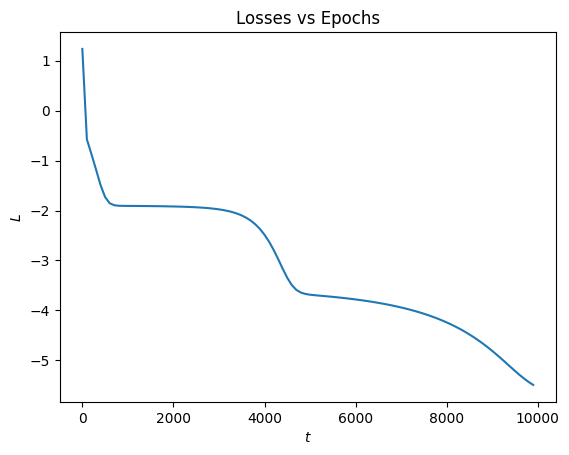

In [5]:
epochs = 10000     # how many iterations to train the model for
n = 4              # the number of dimensions to try for the A, B matrices
store_loss = 100   # print the loss after this many number of epochs

# multiply parameters by a small factor to help with training in the beginning
mag = 1e-1

# initialize A, B matrices as random, hermitize them, then multiply by mag
seed = 1539
key = jax.random.key(seed)
key1, key2 = jax.random.split(key, 2)
A = jax.random.normal(key1, shape=(n, n), dtype=jnp.complex128)
B = jax.random.normal(key2, shape=(n, n), dtype=jnp.complex128)

A = .5 * (A + A.conj().T)
B = .5 * (B + B.conj().T)

A *= mag
B *= mag

# train the PMM using the same training data we defined before
g_train = jnp.array(g_train)
eigenvalues_train = jnp.array(eigenvalues_train)
A, B, losses = train(A, B, epochs, g_train, eigenvalues_train, store_loss=store_loss)
print(f"Loss at epoch {(len(losses) - 1)* store_loss}: {losses[-1]}")

fig, ax = plt.subplots()
ax.plot(store_loss * np.arange(len(losses)), np.log10(losses), '-')
ax.set_ylabel(r'$L$')
ax.set_xlabel(r'$t$')
ax.set_title(r'Losses vs Epochs')
plt.show()

We ended up with a loss of $3.6\times 10^{-6}$. Given that the loss function we used measures mean squared error, we can expect a deviation from true eigenvalues of around $\sqrt{3.6\times10^{-6}} = 0.002$. This is important to check as we adjust initialization variables. When training, initialization is important. Generally $\beta_1=0.9, \beta_2=0.999$, and $\epsilon = 1\times10^{-8}$ are kept constant, but the step size $\eta$ (we settled for $\eta = 0.001$), the gradient cutoff (we settled for cutoff $=1000$), and how the $A,B$ matrices are initialized (we chose Gaussian randomized matrices with a multiplicative factor of $0.1$ to keep small) are all important to consider. If the step-size is too small, the model might get stuck in a weak minimum, or it might evolve too slowly. If the step size is too large, the model might jump around too violently to settle anywhere. The story's similar if the gradient is allowed to jump around unbounded or if it's cuttoff aggressively. Lastly, if $A, B$ are initialized too large or too far away from the optimum values, they may never reach a good minimum no matter how much the other parameters are adjusted. Of course, the form of the loss function is important too. Mean squared error is a good choice.

### (5) Now that we've trained the PMM, we can predict eigenvalues for different values of g using the model


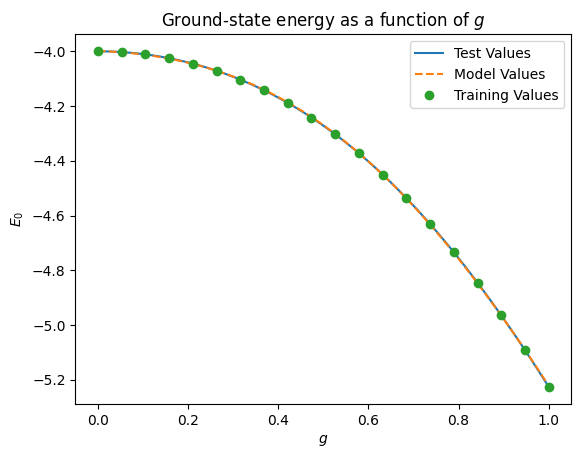

In [6]:
g_test = jnp.array(g_test)
eigenvalues_model = get_eigenvalues(M(A, B, g_test), k_num)

fig, ax = plt.subplots()
ax.plot(g_test, eigenvalues_test[:,:2], '-', label='Test Values')
ax.plot(g_test, eigenvalues_model[:,:2], '--', label='Model Values')
ax.plot(g_train, eigenvalues_train[:,:2], 'o', label='Training Values')
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$E_0$')
ax.set_title(r'Ground-state energy as a function of $g$')
ax.legend()
plt.show()

### Notes on Construction of Ising Hamiltonian (personal use)
The above is using vectorization and bit math to make the construction of the matrices easier. For instance, the $\sigma_{z,i}$ matrices are diagonal: 1s for every diagonal element for which the basis state has a spin-up at the $i$-th site and -1s for every diagonal element for which the basis state has a spin-down at the $i$-th site. This can be done with the following:
```
    for jj in range(2**N):
      # check if the jj basis state has an up or down spin at site i
      sign = (jj // 2**i) % 2
      zs[jj] = (-1)**sign
```
but `zs = (-1)**( (np.arange(2**N) >> i) & 1 )` is much cleaner and quicker. It says: construct a vector of integers from 0 to $2^N-1$, when viewing these integers in base 2, shift the bits $i$ slots to the right. This makes the $2^i$ slot the least significant bit. Bitwise AND (`&`) this number with 1 to isolate the least significant bit. If it's zero (spin up), the diagonal should have a +1; if it's 1 (spin down), the diagonal should have a -1. <br>

Similarly for $\sigma_{x,i}$. The following can construct these matrices:
```
    data, rows, cols = [], [], []
    for jj in range(2**N // 2):
      data.append(1.0)
      rows.append(jj)
      cols.append(jj ^ 2**i)
      data.append(1.0)
      rows.append(jj ^ 2**i)
      cols.append(jj)
    sigmas_at_site_i.append( ss.coo_matrix((data, (rows, cols)), shape=(2**N, 2**N), dtype=np.complex128).tocsr() )
```
But, it is much cleaner and quicker to do
```
    data = np.ones(2**N, dtype=np.complex128)
    rows = np.arange(2**N)
    cols = rows ^ (1 << i)
```
which says: construct a vector of integers from 0 to $2^N-1$ (these will be the row numbers) and construct a vector of column numbers that grabs each row value and flips the $i$-th bit (by doing a XOR operation with the row number and $2^i$ [$2^i$ is given by shifting the bit 1 $i$ bits to the left]).

### Notes on Adam Gradient Descent and Optimization Techniques (personal use)

We start with some definition for a loss function:
$$
  L = \frac{1}{N}\sum_i \sum_{j\ne y_i} \left(\text{max}(0, f(x_i, W)_j - f(x_i, W)_{y_i} + \Delta)\right) + \alpha R(W).
$$
Here, $\{x_i\}_i$ are training points, $W$ are free parameters, and $f(x_i, W)_j$ is a scoring function that gives a measure of how likely our model says the training point $x_i$ is a member of label $j$ (in image classification problems, $x_i$ could be a picture of an apple, and $j$ could be the label "banana". So, $f(x_i, W)_j$ would tell us how much our model thinks the apple picture looks like a banana), $y_i$ is the true label of $x_i$ (in our image classification example, $y_i$ would be "apple"). Thus, a good model would have $f(x_i, W)_j - f(x_i, W)_{y_i} < 0$ (the model should always give "$x_i$ being label $j$" a smaller score than "$x_i$ being label $y_i$" because $y_i$ is the true label, and $j\ne y_i$). In this loss function, we define it so that if $f(x_i, W)_j$ is within $\Delta$ of $f(x_i, W)_{y_i}$, the loss for that training point is positive (we'd only get zero loss if $f(x_i, W)_j < f(x_i, W)_{y_i}-\Delta$). The total loss, $L$, is then given by taking the average of the loss at each training point. $\alpha R(W)$ is a regularization term that keeps the free paramters in check while optimizing: it's often added so that $W$ aren't overfit when optimizing or so the optimization procedure stays stable. <br> <br>

The goal is to adjust the parameters $W$ so that $L$ is minimized. The way we do this is with gradient descent. Ideally, we'd adjust $W$ until we reach the global minimum of $L$ (whether this is guaranteed to happen depends on the type of surface that $L(W)$ forms). To adjust $W$ towards minimum $L$, we can start moving it in the direction that decreases $L$ the most. This is given by $-\nabla_WL$. Thus, one procedure to adjust $W$ is
$$
W_{t+1} = W_t -\eta \nabla_W L
$$
where $\eta$ is some step size. We'd randomly choose $W$, calculate the gradient of the loss for $W$, then adjust $W$ according to the formula above. We'd continue this procedure several times until the loss looks like it's converged to a minimum value. If the error surface $L(W)$ is convex, this procedure is guaranteed to converge to the global minimum. If it's non-convex, this procedure is guaranteed to converge to a local minimum. <br> <br>

The above algorithm, called bulk-batch gradient descent (BBGD), involves calculating the total loss (averaging over all training points) each iteration. This converges nicely, but is memory-intensive, slow, and so stable that the procedure could get stuck in a less-than-optimal local minimum. An alternative is stochastic gradient descent (SGD). Define
$$
  \mathcal{L}(x_i, y_i, W) = \sum_{j\ne y_i} \text{max}(0, f(x_i, W)_j - f(x_i, W)_{y_i} + \Delta)\\
  L=\frac{1}{N}\sum_i \mathcal{L}(x_i, y_i, W) + \alpha R(W)
$$
In SGD, we update $W$ via the following:
$$
W_{t+1} = W_t - \eta \nabla_W\mathcal{L}(x_i, y_i, W).
$$
I.e., we'd randomly choose $W$, calculate the gradient of the loss at one randomly chosen training point $x_i$ and update $W$ accordingly, then repeat the process, calculating the gradient at a randomly selected training point each time. Because we're randomly selecting the training points, $\mathbb{E}[\nabla L(x_i, y_i, W)] = \frac{1}{N}\sum_i \nabla_W\mathcal{L}(x_i, y_i, W)$; i.e., the expectation of the direction of descent in SGD is equal to the descent direction in BBGD. So, we'd expect that SGD converges to the same point that BBGD does. This is much more memory-efficient, faster, and noisy enough that the procedure can jump around to better minimums, but its noisiness also means that convergence isn't as stable.<br><br>

Mini-batch gradient descent (MBGD) takes the best of both worlds. Here, we calculate the gradient of the loss over a subset of training points, update $W$, then repeat the process, randomizing the subset of training points each time. Specifically,
$$
  W_{t+1} = W_t - \eta \frac{1}{M} \sum_{i\in S_t}\nabla_W \mathcal{L}(x_i, y_i, W),
$$
where $S_t$ is the subset of indices corresponding to the mini-batch of training data at iteraction $t$ (randomized each iteraction), and $M=|S_t|$ is the number of elements in the subset. <br><br>

That is the general procedure, but there are tweaks that can be made to optimize the algorithm further. First, SGD often has trouble nagivating ravines (areas where the error surface curves much more steeply in one direction than in another). Often, SGD will oscillates across the steep slopes and only move very slowly down the other direction toward the local minimum. To help push it along, we incorporate momentum:
$$
v_t = \gamma v_{t-1} - \eta\nabla_WL\\
W_{t+1} = W_t + v_t,
$$
For some $\gamma < 1$. Here, we're treating the step parameter, $v_t$, as a speed, and $-\eta \nabla_W L$ as an acceleration. If, as we iterate, the gradients keep pointing in the same direction, the step parameter gets larger (momentum accumulates). If the direction of the gradient changes, the steps will start shrinking (the accumulated momentum will begin to be canceled out). $\gamma$ is a damping factor: it controls how much of the previous velocity is carried forward. As long as $\gamma < 1$, the step sizes will be bound by a terminal velocity (this can be seen by assuming the gradient term is constant and computing the recurrence; it's the same reason that a damping factor in Newtonian air resistance models results in a terminal velocity). <br> <br>

This momentum-based SGD is helpful for breaking past ravines, but it's slightly unstable -- if we don't keep the momentum in check, the step size could blow up enough to overshoot a minimum before it has a chance to slow down. We want the step sizes to be slightly smarter. We want step sizes that "know" where they are on the surface, so they can slow down before a hill slopes up again. This is exactly what the Adaptive Moment Estimation (**ADAM**) algorithm does. To stop the steps from becoming too large when the gradient is steep, we divide the step size by a running average of the squared gradient:
$$
  m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t^2\\
  g_t = \nabla_W L,
$$
for some parameter $\beta_1$. If one expands this out, one finds, $m_t=(1-\beta_1)\sum_{k=0}^t \beta_1^kg_{t-k}^2$. Thus, $m_t$ is a weighted average of the squared gradients: squared gradients from the deep past are suppressed. Dividing the step size by $\sqrt{m_t} + \epsilon$ (where $\epsilon$ is an extremely small number just there to prevent division by zero) will ensure that the step size is dynamic: if the gradient is continually steep, this running average will spike, and the step size will shrink; if the gradient is continually shallow, this running average will flatline, and the step size will grow. The squared gradient gives a measure of curvature, or how steep the hills are. We want to adjust the step size so that the steps slow down a bit if the hills are really steep. Most importantly, since we're using a running average (rather than just dividing by the sum of the squared gradients), the step size can respond to changes in the surface, where more recent changes have a greater effect. Now, we can incorporate momentum. We do this in mostly the same way that we did before, but, sticking to this running averages idea, let's express the momentum-evolved step parameter as a running average of the gradient:
$$
  v_t = \beta_2 v_{t-1} + (1 - \beta_2)g_t
$$

for some parameter $\beta_2$. Then, the momentum-adjusted step parameter is $-\eta v_t$. Dividing by $\sqrt{m_t} + \epsilon$ to keep the momentum-adjusted step paramter in check, we find,
$$
  W_t = W_{t-1} - \frac{\eta}{\sqrt{m_t}+\epsilon} v_t.
$$
One last nuance, $m_t$ and $v_t$ are usually initialized as zero vectors in practice. This biases the $v_t$ and $m_t$ toward zero for early time steps. To get rid of this bias, Adam uses
$$
  \hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t},
$$
$$
   W_t = W_{t-1} - \frac{\eta}{\sqrt{\hat{m}_t}+\epsilon} \hat{v}_t.
$$
In general, this method says: adjust the parameters in the direction of steepest descent; if the gradient continues to point in the same direction, increase the step size (give the steps momentum), but, adjust this momentum-step size so that the steps don't fly down steep hills so fast that they overshoot. In most practical applications, Adam calculates the loss with the MBGD.
<br><br>
A very nice summary of gradient ascent methods can be found in the following links:<br>
https://www.ruder.io/optimizing-gradient-descent/ <br>
https://cs231n.github.io/optimization-1/?ref=ruder.io

### Connection between PMM and EC
In EC, we have a Hamiltonian $H = H_0 + cH_1$, where $c$ is some coupling parameter. We'd like to diagonalize the Hamiltonian at a target value $c^*$. Rather than diagonalizing at this target value directly, we choose a sample set of coupling parameters, $\{c_i\}_i$, diagonalize the Hamiltonian exactly at these points to find sample eigenvectors, $\{v_i\}_i$, and then project the Hamiltonian at $c^*$ onto the subspace spanned by $\{v_i\}_i$:
$$
  H^{(c^*)}_\text{proj} \bar{c} = E \bar{S}\bar{c},
$$
where $\left(H^{(c^*)}_\text{proj}\right)_{ij}=\langle v_i|H^{(c^*)}|v_j\rangle$ is the projected Hamiltonian, and $\bar{S}_{ij} = \langle v_i|v_j\rangle$ is the overlap matrix. The big assumption here is that the eigenvectors of $H^{(c^*)}$ exist in the span of the sample eigenvectors. It can be shown that this assumption is reasonable for a few eigenvectors / eigenvalues of $H^{(c^*)}$: the eigenvectors of $H$ are analytic functions of $c$ if $H$ is an analytic function of $c$. As $c$ varies, an eigenvector is unlikely to explore the entire Hilbert space; it will explore only a small subset of the total Hilbert space. So, it's reasonable to argue that the ground state (for example) eigenvector at $c^*$ exists in the span of the ground state eigenvectors at a few sample points $c_i$ (Taylor expanding an eigenvector in $c$ and looking at the finite difference limit of the derivatives makes this more precise). <br> <br>


In PMM, we start with a set of primary matrices $P_i$, for which we compute the eigenvectors $\{v_i\}_i$ and eigenvalues. The entries of the $P_i$ matrices serve as the free parameters that we adjust during training. Next, we compute the matrix elements of a set of secondary matrices $O_k$ in the basis of the $P_i$ eigenvectors:  

$$
  \langle v_i | O_k | v_j \rangle
$$  

These matrix elements correspond to observables that we want our model to reproduce. The loss function measures the deviation of these predicted observables from their true values, and we iteratively update the parameters of $P_i$ to minimize this loss. Promoting EC to PMM involves treating $H^{(c^*)}$ as the primary and secondary matrix. In EC, we compute the projected Hamiltonian matrix exactly, but, in PMMs, the goal is to treat it as a free parameter, and adjust it to match data.
<br><br>
One nuance: if we treat the projected Hamiltonian as the secondary matrix in which to measure observables, then the idea would be
$$
  \langle v_j | H^{(c^*)}_\text{proj} | v_i \rangle = E^{(c^*)} \delta_{ij}
$$
(i.e., the eigenvector basis is assumed orthonormal), but, in standard EC, the eigenvectors and eigenvalues of the projected Hamiltonian aren't the exact energy eigenstates and eigenvalues because of the overlap matrix. Nevertheless, in EC, one could always Gram-Schmidt the sampled eigenvectors to find an orthonormal basis that spans the same subspace. This is possible because the sampled eigenvectors are almost certainly linearly-independent. If they weren't(i.e., if $\bar{S}$ were singular), then we could just choose a different sample point where the linear dependence is broken. Thus, while useless in standard EC, we could always manipulate the sample eigenvector basis to get $\bar{S}=I$. In PMMs, we construct $H_\text{proj}^{(c^*)}$ to be Hermitian by design. Thus, by construction, we're enforcing this orthonormal basis condition. By doing so, we enforce the orthonormal basis condition from the start, effectively bypassing the need to handle an overlap matrix at all.